## Effects of gravity on Bondi–Hoyle–Lyttleton accretion

### Hoyle & Lyttleton (1939) linear wake
In the original HL39 version of BHL accretion, the streams on opposite sides of the star currve towards the symmetry axis as  they pass the star (hyperbolic orbit) and collide on the symmetry axis to form a wake line. A stream with impact parameter b hits the axis at a position z = p/2, where p is the semi-latus rectum of the hyperbola. 

The collision cancels the x, y velocity components, leaving only the z component, v_z. By considering angular momentum conservation, HL show that v_z = v_0, which is the inflow velocity at infinity. 

The condition for accretion is then that the total energy at z (kinetic plus gravitational) should be negative, so the shocked stream cannot escape from the accretor: 1/2 v_z^2 < G M_2 / z

z < 2 G M_2 / v_0^2

Also, the specific angular momentum h = v_0 b = sqrt(G M_2 p) **this last equality I still need to derive**

So that p = v_0^2 b^2 / G M_2 and z = v_0^2 b^2 / 2 G M_2

Hence the condition is b^2 < (2 G M_2 / v_0^2) (2 G M_2 / v_0^2) **I have written it like this for a reason** 

Which gives the classic BHL radius: r_BHL = 2 G M_2 / v_0^2

In terms of this, we can write the impact point on the wake line as z = b^2 / r_BHL

### Modification for gravitational perturbation of primary
***This whole section needs revisiting in light of Roche lobe calculations*** 

If the secondary is not isolated, then the accretion condition needs to be modified. Instead of escaping to infinity, the shocked stream need only reach the boundary of the Roche lobe of the secondary. So

1/2 v_z^2 < G M / z - G M / r_g

where r_g is the radius of the sphere of influence (still to be determined).

This can be solved to give a modified condition on the impact parameter:

b < r_BHL / sqrt(1 + r_BHL / r_g)

So we see that the accretion radius is in general reduced. This is fine if r_g > r_BHL since then, we can justifiably ignore the perturbation of the incoming stream

**However, it is not valid for r_g < r_BHL**

This is because we need for the incoming stream to enter the sphere of influence of the secondary, otherwise there will be no deflection towards the axis/ at all. So for r_g < r_BHL we can use b < r_g / sqrt(2)

The sqrt(2) factor is so that we match up at r_g = r_BHL.  But it would be nice to have a more exact theory, although that would be difficult. 



## Effective potential in rotating frame

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.optimize import fsolve


### Net potential functions

In [51]:
def Uw(x, q):
    """My version along the star-star axis, centered on secondary
    
    Normalized by Omega^2 = G M / a
    """
    primary = (1 - q) / np.abs(x + 1)
    secondary = q / np.abs(x)
    centrifugal = 0.5 * (x + 1 - q)**2
    return -(primary + secondary + centrifugal)

def Uexternal(q, Gamma=0):
    """Potential at secondary due to primary plus centrifugal

    The secondary gravity still needs to be added

    Same units as Us()
    """
    return -(2 * (1 - q) * (1 - Gamma) + (1 - q)**2)

def Us(x, q, y=0, z=0, Gamma=0.0):
    """Seldov 2004ApJ...603..283S Equation 1, centered on primary

    Normalized by G (M1 + M2) / (2 A)

    This supposedly follows Mochnaki (1984) but I huave not read that yet

    Modified to include an Eddington factor, Gamma, for the primary,
    which models continuum radiative acceleration on wind
    """
    # The Roche lobe literature uses a different definition of q
    Q = q / (1 - q)
    return -(
        (x - Q / (1 + Q)) ** 2
        + y ** 2
        + 2 * Q / (1 + Q) / np.sqrt(
            (-1 + x) ** 2 + y ** 2 + z ** 2
        )
        + 2 * (1 - Gamma) / (1 + Q) / np.sqrt(
            x ** 2 + y ** 2 + z ** 2
        )       
    )

These agree if we shift the x value to account for the different origins and scale to account for different normalizations.

For example with $q = 0.5$ and displacement of $+0.1 a$ from secondary:

In [53]:
0.5 * Us(0.1 + 1, 0.5), Uw(0.1, 0.5)

(np.float64(-5.634545454545449), np.float64(-5.634545454545454))

### Different radii of the Roche lobe

The definition of the Roche lobe is the equipotential surface that passes through the L1 point (on the line between the two stars). So this is slightly different from the Hill sphere, which is based on comparing central and tidal forces at each point.

In [4]:
xgrid = np.linspace(-3.5, 2.5, 200)

In [8]:
def h_approx(q):
    """Approximate form for Roche radius for small q"""
    return 0.462 * q ** (1/3)
    
def h1_func(h, q, Gamma=0):
    """Net force that is zero at inner Lagrange point"""
    return q / h**2 - (1 - q) * (1 - Gamma) / (1 - h)**2 + 1 - q - h

def h2_func(h, q, Gamma=0):
    """Net force that is zero at outer Lagrange point"""
    return -q / h**2 - (1 - q) * (1 - Gamma) / (1 + h)**2 + 1 - q + h


@np.vectorize
def h1(q, Gamma=0):
    """Exact radius from secondary of inner Lagrange point L1"""
    return fsolve(h1_func, x0=h_approx(q), args=(q, Gamma))

@np.vectorize
def h2(q, Gamma=0):
    """Exact radius from secondary of outer Lagrange point L2"""
    return fsolve(h2_func, x0=h_approx(q), args=(q, Gamma))

@np.vectorize
def hh(q, hfunc=h1_func):
    """Exact radius from secondary of lateral boundary of Roche lobe"""
    _h = fsolve(hfunc, x0=h_approx(q), args=(q,))
    # Find potential at L1 point
    UL1 = Us(x=(1 - _h), q=q, y=0, z=0)
    # Find y displacement where potential is the same
    return fsolve(
        lambda x: Us(x=1, q=q, y=x) - UL1,
        x0=_h,
    )

@np.vectorize
def hz(q, hfunc=h1_func):
    """Exact radius from secondary of orbital-polar boundary of Roche lobe"""
    _h = fsolve(hfunc, x0=h_approx(q), args=(q,))
    # Find potential at L1 point
    UL1 = Us(x=(1 - _h), q=q, y=0, z=0)
    # Find z displacement where potential is the same
    return fsolve(
        lambda x: Us(x=1, q=q, z=x) - UL1,
        x0=_h,
    )
    
@np.vectorize
def hx(q, hfunc=h1_func):
    """Exact radius from secondary of outside x boundary of Roche lobe"""
    _h = fsolve(hfunc, x0=h_approx(q), args=(q,))
    # Find potential at L1 point
    UL1 = Us(x=(1 - _h), q=q, y=0, z=0)
    # Find outer x displacement where potential is the same
    return fsolve(
        lambda x: Us(x=1 + x, q=q) - UL1,
        x0=_h,
    )

def h_egg(q):
    """Average radius of Roche lobe due to Eggleton 1983ApJ...268..368E"""
    Q = q / (1 - q)
    y = Q ** (1.0 / 3.0)
    return np.where(
        q == 0.0,
        0.0, # special case to avoid nan
        0.49 * (y ** 2) / (0.6 * (y ** 2) + np.log(1 + y))
    )

In [9]:
h_egg(0)

array(0.)

/var/folders/0q/3pcjvc3n6sn2wk6g8ck6ry300000gn/T/ipykernel_21252/783046968.py:17: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  return fsolve(h1_func, x0=h_approx(q), args=(q, Gamma))
/var/folders/0q/3pcjvc3n6sn2wk6g8ck6ry300000gn/T/ipykernel_21252/783046968.py:22: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  return fsolve(h2_func, x0=h_approx(q), args=(q, Gamma))
/var/folders/0q/3pcjvc3n6sn2wk6g8ck6ry300000gn/T/ipykernel_21252/783046968.py:27: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  _h = fsolve(hfunc, x0=h_approx(q), args=(q,))
/var/folders/0q/3pcjvc3n6sn2wk6g8ck6ry300000gn/T/ipykernel_21252/783046968.py:31: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  return fsolve(
/va

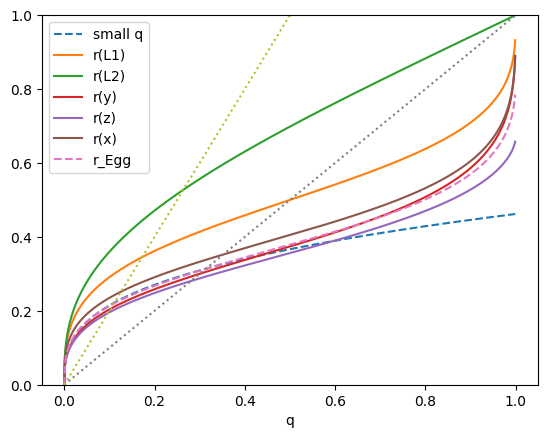

In [10]:
fig, ax = plt.subplots()
qgrid = np.linspace(0.0, 1.0, 1000, endpoint=False)
np.seterr(all="ignore")
ax.plot(qgrid, h_approx(qgrid), ls="dashed", label="small q")
ax.plot(qgrid, h1(qgrid), label="r(L1)")
ax.plot(qgrid, h2(qgrid), label="r(L2)")
ax.plot(qgrid, hh(qgrid, hfunc=h1_func), label="r(y)")
ax.plot(qgrid, hz(qgrid, hfunc=h1_func), label="r(z)")
ax.plot(qgrid, hx(qgrid, hfunc=h1_func), label="r(x)")
ax.plot(qgrid, h_egg(qgrid), ls="dashed", label="r_Egg")
ax.plot(qgrid, qgrid, ls="dotted")
ax.plot(qgrid, 2 * qgrid, ls="dotted")
ax.legend()
ax.set(ylim=[0, 1], xlabel="q")
...;

In [11]:
h_approx(0.5), h1(0.5), h2(0.5), hh(0.5), hz(0.5), h_egg(0.5)

(0.3666896430046541,
 array([0.5]),
 array([0.69840614]),
 array([0.37404615]),
 array([0.35613087]),
 array(0.37892052))

So this now is looking a lot more consistent. The Roche lobe radius in all the different directions is very similar, and is always quite a bit less than the L1 radius, which is because it points out like a nose there. The L2 radius is even bigger, but that is not so relevant since the material will not be accreted if it passes over the L1 equipotential surface. 

 **I will use the Eggleton approx for the capture calculation** (pink dashed line in graph) since it is a good approximan to the Roche surface radius. 

### Effective potentials along the x-axis

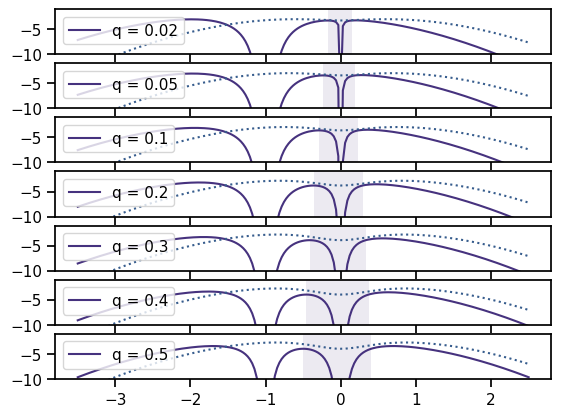

In [54]:
qrange = 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5
fig, axes = plt.subplots(len(qrange), 1, sharex=True)
for ax, q in zip(axes, qrange):
    line, = ax.plot(xgrid, 2 * Uw(xgrid, q), label=f"q = {q}")
    line, = ax.plot(xgrid, Us(1 - h1(q), q, y=xgrid), label=None, ls="dotted")
    ax.set(
        ylim=[-10, -1],
    )
    r = (q / 3)**(1/3)
    ax.axvspan(-h1(q)[0], hx(q)[0], alpha=0.1)
    ax.legend(loc="upper left")
...;

The blue shaded band is between L1 and the point at the same potential on the other side. 

We can probably get an exact result for U(L1) from the approach of Seidov (2004), which recognises the following. Although one cannot write a simple exact closed form for R1(q), one *can* do it for q(R1) and also for U(R1). 

### Effects of Eddington factor

For a neutral dusty wind, the effective Eddington factor can be pretty large, even potentially bigger than unity.

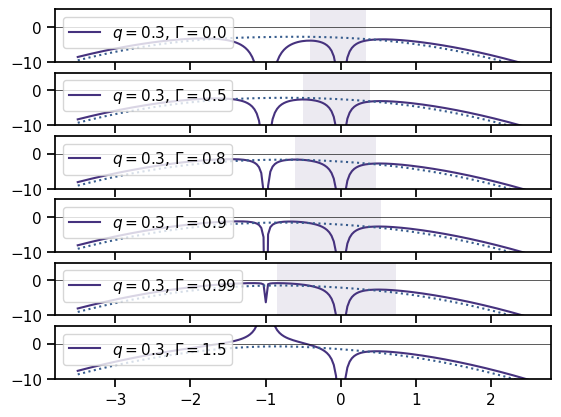

In [36]:
q = 0.3
Grange = 0.0, 0.5, 0.8, 0.9, 0.99, 1.5
fig, axes = plt.subplots(len(Grange), 1, sharex=True)
for ax, Gamma in zip(axes, Grange):
    line, = ax.plot(xgrid, Us(1 + xgrid, q, Gamma=Gamma), 
                   label=fr"$q = {q}$, $\Gamma = {Gamma}$")
    line, = ax.plot(xgrid, Us(1 + xgrid, q, y=1, Gamma=Gamma), label=None, ls="dotted")
    ax.set(
        ylim=[-10, 5],
    )
    r = (q / 3)**(1/3)
    qprime = q / (q + (1 - q) * (1 - Gamma))
    if qprime > 0:
        ax.axvspan(-h1(q, Gamma)[0], hx(qprime)[0], alpha=0.1)
    ax.axhline(0.0, lw=0.5, color="k")
    ax.legend(loc="upper left")
...;

## Potential along the accretion line

We need to climb from (U_ext - G M / z) up to U_L1, where

$$
U_\mathrm{ext} = (3 - q) (q - 1)
$$

In [14]:
def rB(q, w=0):
    """Hole-Lyttleton accretion radius in units of a"""
    return 2 * q / (1 + w**2)

In [73]:
def UL1(q, Gamma=0):
    return Us(x=(1 - h1(q, Gamma)), q=q, y=0, z=0, Gamma=Gamma)

def UL2(q, Gamma=0):
    return Us(x=(1 + h2(q, Gamma)), q=q, y=0, z=0, Gamma=Gamma)

from scipy.optimize import minimize

@np.vectorize
def Umax(q, Gamma=0):
    """
    Find the maximum potential
    """
    fun = lambda x: -Us(x=x[0], q=q, y=x[1], z=0, Gamma=Gamma)
    bounds = ((-2, 2), (0, 2))
    result = minimize(fun, (0.5, 1), bounds=bounds)
    x, y = result.x
    return float(Us(x=x, q=q, y=y, z=0, Gamma=Gamma))

In [71]:
Umax(0.5)

-2.7500000000104246

/var/folders/0q/3pcjvc3n6sn2wk6g8ck6ry300000gn/T/ipykernel_21252/783046968.py:17: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  return fsolve(h1_func, x0=h_approx(q), args=(q, Gamma))
/var/folders/0q/3pcjvc3n6sn2wk6g8ck6ry300000gn/T/ipykernel_21252/783046968.py:22: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  return fsolve(h2_func, x0=h_approx(q), args=(q, Gamma))


[(-8.395700999999999, 0.397699),
 Text(0.5, 0, 'q'),
 Text(0, 0.5, 'Potential $U / (G M / 2 a)$')]

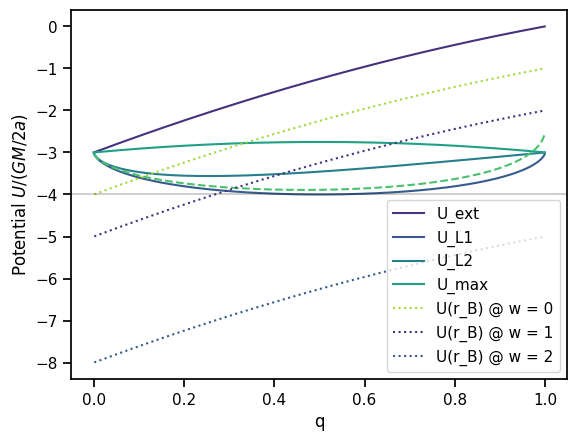

In [75]:
fig, ax = plt.subplots()
qgrid = np.linspace(0.0, 1.0, 1000, endpoint=False)
np.seterr(all="ignore")
ax.plot(qgrid, Uexternal(qgrid), label="U_ext")
ax.plot(qgrid, UL1(qgrid), label="U_L1")
ax.plot(qgrid, UL2(qgrid), label="U_L2")
ax.plot(qgrid, Umax(qgrid), label="U_max")
ax.plot(qgrid, (3 - qgrid) * (qgrid - 1) - 2 * qgrid / h_egg(qgrid), linestyle="dashed")
for w in 0, 1, 2:
    ax.plot(
        qgrid, 
        (3 - qgrid) * (qgrid - 1) - 2 * qgrid / rB(qgrid, w=w), 
        linestyle="dotted",
        label=f"U(r_B) @ w = {w}",
    )
ax.axhline(-4, lw=0.3, color="k")
ax.legend()
ax.set(
    ylim=[None, None], 
    xlabel="q",
    ylabel="Potential $U / (G M / 2 a)$")

## Revisiting HL39 in Roche potential

We now have the elements necessary for calculating r_acc in the binary potential. We first find the escape radius from the condition
$$
\frac12 v^2 = U(r_e) - U(L_1)
$$
where $v$ is the local relative velocity in frame of secondary and $U$ is the total potential, evaluated at the local point and the L1 point. 

We now use binary orbit units:
* Lengths in units of separation $a$
* Potential in units of $  \frac12  \Omega^2 = G (M_1 + M_2) / (2 a)$

Assuming $v$ is the incoming relative wind velocity, then the kinetic energy in these units is $1 + w^2$.

The Roche potential at the L1 point is 
$$
U(L_1) = -(3 + f(q))
$$
where $f(q) \approx 9 (q/3)^{2/3}$ for small $q$, rising to unity at $q=0.5$ and then falling again with $f(q) = f(1 - q)$. 

The potential at separation from the secondary $r_2 = r_e$ is
$$
U(r_e) \approx - \frac{2 q}{r_e} - (3 - q) (1 - q)
$$
where the second term is the background potential due to the primary and the centrifugal force. In reality, this will vary with direction from the secondary, but we are approximating it by calculating it at the secondary position, which is valid for small $r_e$. 

Putting this together gives
$$
r_e \approx \frac{2 q}{1 + w^2 + q (4 - q) + f(q)} ,
$$
which can be compared with the standard Hoyle–Lyttleton result
$$
r_0 = \frac{2 q}{1 + w^2} ,
$$
yielding 
$$
r_e = \frac{r_0}{1 + (2 - \frac12 q) r_0 + f(q)/ (1 + w^2)}
$$
Although I am not sure if we really gain much by writing it like that.  

We also have the maximum potential which is about $-3$ for $q$ or $1 - q$ small, rising to maximum of $-2.75$ at $q=0.5$

In [79]:
def ff(q):
    """The correction function in the L1 potential"""
    return -UL1(q) - 3

def r_escape(q, w):
    """Escape radius from secondary to L1 potential

    Where KE is bigger than potential difference from Roche surface
    """
    return 2 * q / (
        1 + w**2 + q * (4 - q) + ff(q)
    )

def r_e_to_max(q, w):
    """Escape radius from secondary to L4, L5 (maximum) potential
    """
    return 2 * q / (
        1 + w**2 + q * (4 - q) - 0.25 * ff(q)
    )

def r_bhl(q, w):
    """Classical Hoyle–Lyttleton radius
    """
    return 2 * q / (1 + w**2)

In [18]:
sns.set_color_codes("deep")
sns.set_context("notebook")

/var/folders/0q/3pcjvc3n6sn2wk6g8ck6ry300000gn/T/ipykernel_21252/783046968.py:17: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  return fsolve(h1_func, x0=h_approx(q), args=(q, Gamma))


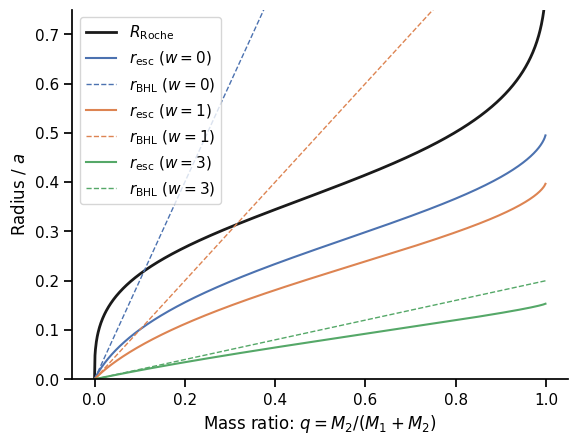

In [77]:
sns.set_palette("deep")


fig, ax = plt.subplots()
qgrid = np.linspace(0.0, 1.0, 1000, endpoint=False)
ax.plot(qgrid, h_egg(qgrid), lw=2, color="k", label=r"$R_\mathrm{Roche}$")
for w in 0, 1, 3:
    line, = ax.plot(qgrid, r_escape(qgrid, w), 
            label=fr"$r_\mathrm{{esc}}$ ($w={w}$)",
           )
    ax.plot(qgrid, r_bhl(qgrid, w), 
            ls="dashed", 
            lw=1,
            label=fr"$r_\mathrm{{BHL}}$ ($w={w}$)",
            color=line.get_color(),
           )
    # ax.plot(qgrid, np.sqrt(r_bhl(qgrid, w) * r_escape(qgrid, w)),
    #         ls="dotted", 
    #         color=line.get_color(),
    #         label=None,
    #        )
ax.legend(loc="upper left")
ax.set(
    ylim=[0, 0.75], 
    xlabel="Mass ratio: $q = M_2 / (M_1 + M_2)$",
    ylabel="Radius / $a$",
)
sns.despine()
fig.savefig("roche-accretion-radii-vs-q.pdf")
...;

Now the same, but with escape to L4

/var/folders/0q/3pcjvc3n6sn2wk6g8ck6ry300000gn/T/ipykernel_21252/783046968.py:17: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  return fsolve(h1_func, x0=h_approx(q), args=(q, Gamma))


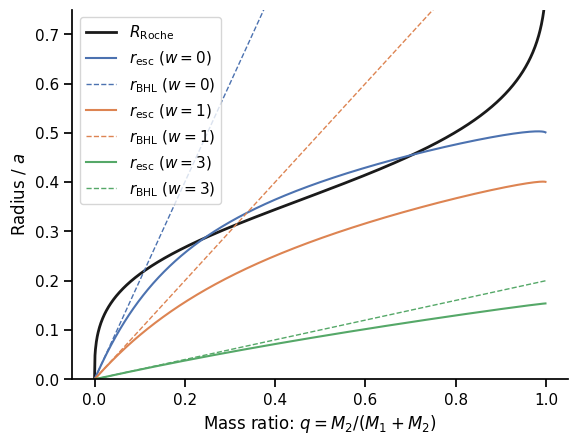

In [90]:
sns.set_palette("deep")


fig, ax = plt.subplots()
qgrid = np.linspace(0.0, 1.0, 1000, endpoint=False)
ax.plot(qgrid, h_egg(qgrid), lw=2, color="k", label=r"$R_\mathrm{Roche}$")
for w in 0, 1, 3:
    line, = ax.plot(qgrid, r_e_to_max(qgrid, w), 
            label=fr"$r_\mathrm{{esc}}$ ($w={w}$)",
           )
    ax.plot(qgrid, r_bhl(qgrid, w), 
            ls="dashed", 
            lw=1,
            label=fr"$r_\mathrm{{BHL}}$ ($w={w}$)",
            color=line.get_color(),
           )
ax.legend(loc="upper left")
ax.set(
    ylim=[0, 0.75], 
    xlabel="Mass ratio: $q = M_2 / (M_1 + M_2)$",
    ylabel="Radius / $a$",
)
sns.despine()
fig.savefig("roche-escape-L4-radii-vs-q.pdf", bbox_inches="tight")
...;

How the r_e effects the accretion radius depends on where we apply the escape criterion. If we apply it on the wake line, then we get $z < r_e$, but $z/b = b/r_0$ (at least for the normal HL case, so this gives $b^2 = r_0 z$. Then if we set accretion radius to be $r_\mathrm{acc} = b$, then we have
$$
r_\mathrm{acc} = (r_0 r_e)^{1/2} .
$$

However, I do not like this, since it does not account for the lowering of the effective gravitational attraction of the secondary in the outer zones of the Roche lobe. Also, it results in accretion radii bigger than the Roche lobe for small $w$.

A better way is to apply might be just to apply it to the incoming stream and say that a stream with $b > r_e$ will not be accreted:
$$
r_\mathrm{acc} = r_e .
$$
However, it turns out that if we do that then the accretion efficiency is far too low compared with the simulations around $w = 0.5$. 

So I have gone back to the first version above, but with a cut-off at the Roche radius. To do a better job, I will have to do some trajectory integrations in the effective potential, which seems like a lot of work. 

In [91]:
def vr_over_vw(w):
    """Ratio v_r / v_w 
    
    Ratio of aberrated wind velocity in frame of secondary

        v_r = sqrt(v_w**2 + v_o**2)
        
    to the wind velocity in frame of primary, v_w. 

    Parameter w is v_w / v_o where v_o is orbital speed
    """
    return np.sqrt(1 + w**2) / w

def eta(q, w, bhl=False):
    """Wind accretion efficiency"""
    r0 = r_bhl(q, w)
    re = r_e_to_max(q, w)
    r_Roche = h_egg(q)
    if bhl:
        rsq = r0 ** 2
    else:
        # rsq = r0 * re
        rsq = re ** 2
        # rsq = np.where(
        #     rsq > r_Roche**2,
        #     r_Roche**2,
        #     rsq,
        # )
    return rsq * vr_over_vw(w) / 4
    

In [92]:
sns.set_palette(sns.mpl_palette("viridis"))

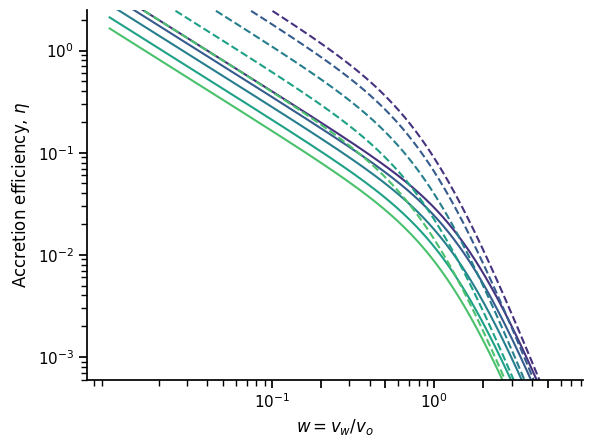

In [93]:
fig, ax = plt.subplots()
wgrid = np.geomspace(0.01, 6.0, 1000)
for q in reversed([1/5, 1/4, 1/3, 3/7, 1/2]):
    line, = ax.plot(wgrid, eta(q, wgrid))
    ax.plot(wgrid, eta(q, wgrid, bhl=True), 
         ls="dashed", color=line.get_color(),
        )

ax.set(
    xscale="log",
    yscale="log",
    ylabel=r"Accretion efficiency, $\eta$",
    xlabel="$w = v_w / v_o$",
    # xlim=[0.08, 6],
    ylim=[6e-4, 2.5],
    xticks=[0.1, 0.2, 0.5, 1, 2, 5],
)
sns.despine()
...;

## Combine Roche with finite refill time

Now we can finally put the two parts together by bringing over functions from the other notebook

### Torus refill functions

In [23]:
def flinear_racc(racc, q, w):
    """Linear refill fraction in terms of accretion radius"""
    h = 2 * racc / np.sqrt(1 + w**2)
    x = 2 * np.pi * w
    return x / h
    
def F_area(f):
    """Fraction of torus area refilled by wind in one orbital period

    In terms of the linear diameter fraction f
    """
    return (
        1 -
        (2 / np.pi) * (
            np.arccos(f) - f * np.sqrt(1 - f**2)
        )
    )
    

### Accretion radius

We need a function explicitly for this, which we will use in place of `r_bhl()`

In [99]:
def r_acc(q, w):
    """Accretion radius with BHL and tidal perturbations"""
    r0 = r_bhl(q, w)
    re = r_e_to_max(q, w)
    # Naive estimate of impact parameter giving z = re
    b = np.sqrt(r0 * re)
    r_Roche = h_egg(q)
    # return np.where(b < r_Roche, b, r_Roche)
    return b
    # return re

### Accretion efficiencies



In [25]:
def vr_over_vw(w):
    """Ratio v_r / v_w 
    
    Ratio of aberrated wind velocity in frame of secondary

        v_r = sqrt(v_w**2 + v_o**2)
        
    to the wind velocity in frame of primary, v_w. 

    Parameter w is v_w / v_o where v_o is orbital speed
    """
    return np.sqrt(1 + w**2) / w

def eta_bhl(q, w):
    """Accretion efficiency in naive BHL case"""
    rsq = r_bhl(q, w) ** 2
    return rsq * vr_over_vw(w) / 4

def eta_best(q, w):
    """More realistic accretion efficiency

    Includes two potential additional effects:

    1. Reduction of r_acc by tidal perturbations
    2. Reduction in accretion area by finite wind refill time
    """
    racc = r_acc(q, w)
    f = flinear_racc(racc, q, wgrid)
    F = np.where(f < 1, F_area(f), 1)
    return F * racc**2 * vr_over_vw(w) / 4


### Plot the accretion efficiency

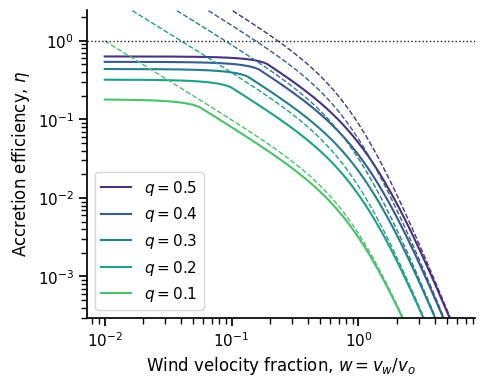

In [100]:
sns.set_palette(sns.mpl_palette("viridis"))

fig, ax = plt.subplots(figsize=(5, 4))
wgrid = np.geomspace(0.01, 6, 200)

for q in reversed([0.1, 0.2, 0.3, 0.4, 0.5]):
    eta0 = eta_bhl(q, wgrid)
    eta = eta_best(q, wgrid)
    line, = ax.plot(
        wgrid, eta,
        label=f"$q = {q}$",
        )
    ax.plot(
        wgrid,
        eta0,
        ls="dashed",
        lw=1,
        color=line.get_color(),
    )
ax.legend()
ax.axhline(1.0, ls="dotted", color="k", lw=1)
ax.set(
    xlabel="Wind velocity fraction, $w = v_w / v_o$",
    ylabel=r"Accretion efficiency, $\eta$",
    xscale="log",
    yscale="log",
    ylim=[0.3e-3, 2.5],
)
sns.despine()
fig.savefig("eta-roche-finite-refill.pdf", bbox_inches="tight")
...;

### Contour plot

[Text(0.5, 0, 'Wind velocity fraction, $w = v_w / v_o$'),
 Text(0, 0.5, 'Mass fraction, $q$'),
 None,
 None]

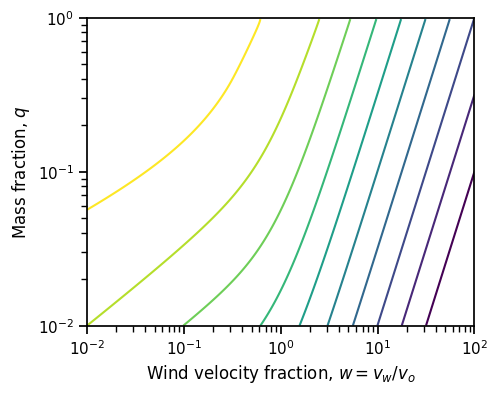

In [97]:
ww = np.geomspace(0.01, 100, 200)
qq = np.geomspace(0.01, 1, 200)

X, Y = np.meshgrid(ww, qq)

fig, ax = plt.subplots(figsize=(5, 4))
levels = np.arange(10) - 10
ax.contour(X, Y, np.log10(eta_best(Y, X)), levels=levels)
ax.set(
    xlabel="Wind velocity fraction, $w = v_w / v_o$",
    ylabel=r"Mass fraction, $q$",
    xscale="log",
    yscale="log",
)

## Figure of example potential surfaces and trajectories

### Wind trajectories in rotating frame

Wind will follow a spiral trajectory:
$$
[r, \theta] = [v_w t, \Omega t]
$$
with $v_w = w v_o$ and $v_o = a \Omega$.

So
$$
r /a = w \theta 
$$

In [46]:
def xy_trajectory(theta_max, w, theta_0=0, npts=200):
    """
    Backwards trajectory of wind in rotating frame
    """
    theta = np.linspace(theta_0, theta_max, npts)
    r = 1 - w * theta
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    x[r < 0] = np.nan
    return x, y, r

In [29]:
def rotate(x, y, angle):
    c, s = np.cos(angle), np.sin(angle)
    return c * x + s * y, -s * x + c * y

### Contours of potentials

In [30]:
from scipy.interpolate import griddata

q=0.2 w=2.0 Umax=-2.84 Uwmax=-3.44 U1=-3.80 dpos=0.11 dneg=0.50
q=0.4 w=2.0 Umax=-2.76 Uwmax=-3.37 U1=-3.98 dpos=0.14 dneg=0.50
q=0.2 w=0.2 Umax=-2.84 Uwmax=-2.91 U1=-3.80 dpos=0.11 dneg=0.50
q=0.4 w=0.2 Umax=-2.76 Uwmax=-2.81 U1=-3.98 dpos=0.14 dneg=0.50


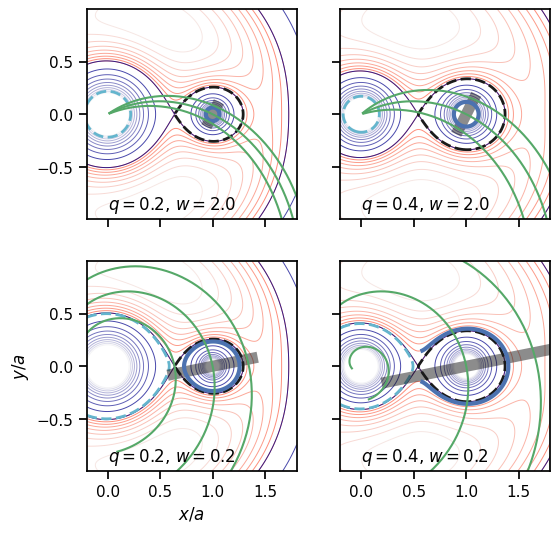

In [101]:
N = 200
x = np.linspace(-0.2, 1.8, N)
y = np.linspace(-1, 1, N)
X, Y = np.meshgrid(x, y)

fig, axes = plt.subplots(2, 2, figsize=(6, 6), sharex=True, sharey=True)
qs = 0.2, 0.4, 0.2, 0.4
ws = 2.0, 2.0, 0.2, 0.2
for q, w, ax in zip(qs, ws, axes.flat):
    U = Us(x=X, q=q, y=Y, z=0)
    Umax = np.max(U)
    U1, = UL1(q)
    # Potential of escape (to Roche lobe) surface 
    Ue = U1 - (1 + w**2)
    # Potential of escape (over Umax) surface 
    Uee = Umax - (1 + w**2)
    # Minimum potential around primary so that wind climb out to L1
    Umin_primary = U1 - w**2

    pos_levels = np.linspace(U1, Umax, 10)
    dpos = np.diff(pos_levels)[0]
    pos_colors = sns.light_palette("tomato", n_colors=len(pos_levels), reverse=True)
    neg_levels = U1 - 0.5 * np.arange(10)[::-1]
    dneg = np.diff(neg_levels)[0]
    neg_colors = sns.light_palette("darkblue", n_colors=len(neg_levels))
    Ulevels = np.array([U1 - 3, U1 - 1, U1, U1 + 0.25, U1 + 0.5, U1 + 0.75])

    ax.contour(X, Y, U, levels=pos_levels, colors=pos_colors, linewidths=0.7, alpha=0.8)
    ax.contour(X, Y, U, levels=neg_levels, colors=neg_colors, linewidths=0.7, alpha=0.8)
    
    # Potential around secondary only
    R1 = h1(q)
    UU = np.where(
        (X > 1 - R1) & (np.hypot(X - 1, Y) < 1.01 * R1), 
        U, 
        np.nan,
    )
    ax.contour(X, Y, UU, levels=[U1], colors="k", linewidths=2)
    # ax.contour(X, Y, UU, levels=[Ue], colors="k", linewidths=2, linestyles="solid")
    # ax.contour(X, Y, UU, levels=[Uee], colors="k", linewidths=2, linestyles="dotted")

    # Potential around primary only
    UUU = np.where(
        (np.hypot(X, Y) < 1 - R1), 
        U, 
        np.nan,
    )
    ax.contour(X, Y, UUU, levels=[Umin_primary], colors="c", linewidths=2)
    
    # BHL radius
    r0 = r_bhl(q, w)
    cth = w / np.sqrt(1 + w**2)
    sth = 1 / np.sqrt(1 + w**2)
    x_bhl = [1 - r0 * sth, 1 + r0 * sth]
    y_bhl = [- r0 * cth, r0 * cth]
    ax.plot(x_bhl, y_bhl, lw=8, alpha=0.5, color="k")
    
    # Wind trajectories
    xw, yw, rw = xy_trajectory(np.pi, w=w, theta_0=-np.pi/2)
    # Max potential along trajectory by interpolation
    Uwmax = np.nanmax(griddata((X.flat, Y.flat), U.flat, (xw, yw)))
    Uwe = Uwmax - (1 + w**2)
    ax.contour(X, Y, UU, levels=[Uwe], colors="b", linewidths=3, linestyles="solid")
    print(f"{q=} {w=} {Umax=:.2f} {Uwmax=:.2f} {U1=:.2f} {dpos=:.2f} {dneg=:.2f}")
    angle = 1.5 * np.arctan(r0 * cth)
    dr = r0 * sth
    rscales = 1 - dr, 1.0, 1 + dr
    angleshifts = -angle, 0, angle
    for rscale, angleshift in zip(rscales, angleshifts):
        xx, yy = rotate(xw, yw, angleshift)
        ax.plot(rscale * xx, rscale * yy, color="g")
    
    ax.text(0.0, -0.9, fr"$q = {q}$, $w = {w}$")
    ax.set_aspect("equal")

axes[-1, 0].set(
    xlabel="$x / a$",
    ylabel=r"$y / a$",
    xlim=[x[0], x[-1]],
    ylim=[y[0], y[-1]],  
    xticks=[0, 0.5, 1, 1.5],
    yticks=[-0.5, 0, 0.5],
)
fig.savefig("roche-potential-trajectories.pdf", bbox_inches="tight")
...;

In [32]:
sns.dark_palette("red", n_colors=6)

[(np.float64(0.19218232522148992),
  np.float64(0.13308584448917626),
  np.float64(0.13306098410197983)),
 (np.float64(0.35374586017719195),
  np.float64(0.10646867559134102),
  np.float64(0.10644878728158387)),
 (np.float64(0.515309395132894),
  np.float64(0.07985150669350576),
  np.float64(0.0798365904611879)),
 (np.float64(0.676872930088596),
  np.float64(0.05323433779567051),
  np.float64(0.05322439364079194)),
 (np.float64(0.838436465044298),
  np.float64(0.026617168897835247),
  np.float64(0.026612196820395964)),
 (np.float64(1.0), np.float64(0.0), np.float64(0.0))]

### Potential contours with Eddington factor



q=0.2 w=2.0 qprime=0.33 Gamma=0.5 Umax=-1.95 Uwmax=-2.88 U1=-2.47 dpos=0.06 dneg=0.50
q=0.4 w=2.0 qprime=0.57 Gamma=0.5 Umax=-2.09 Uwmax=-2.99 U1=-2.79 dpos=0.08 dneg=0.50
q=0.2 w=0.2 qprime=0.71 Gamma=0.9 Umax=-0.96 Uwmax=-1.67 U1=-1.09 dpos=0.02 dneg=0.50
q=0.4 w=0.2 qprime=0.87 Gamma=0.9 Umax=-1.35 Uwmax=-1.89 U1=-1.55 dpos=0.02 dneg=0.50


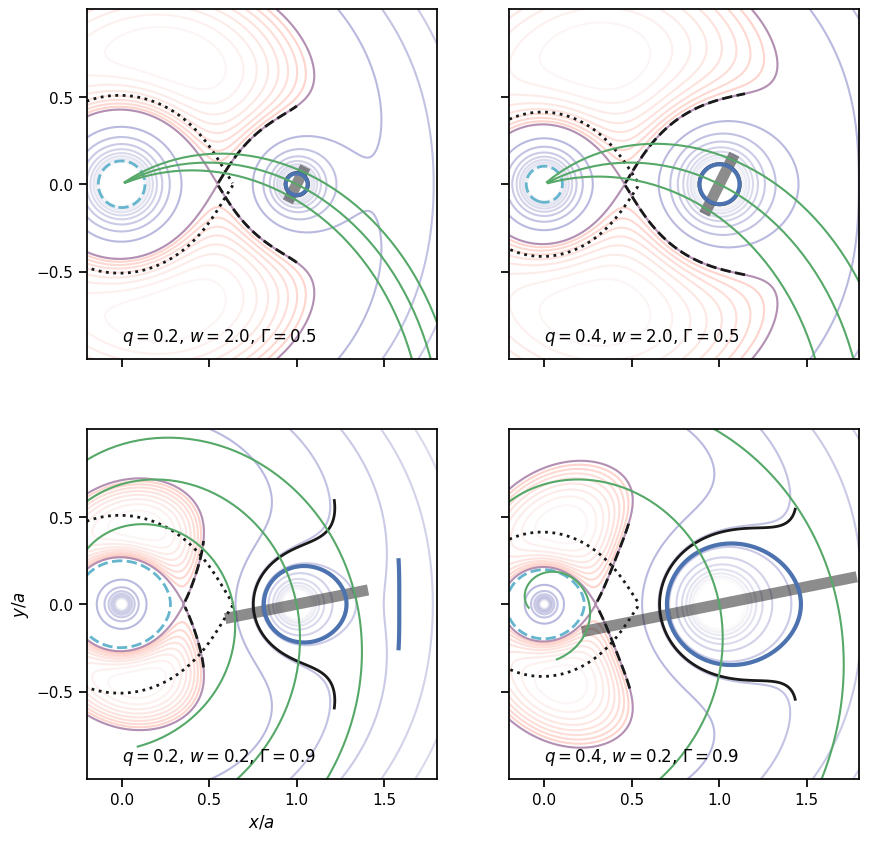

In [89]:
N = 200
x = np.linspace(-0.2, 1.8, N)
y = np.linspace(-1, 1, N)
X, Y = np.meshgrid(x, y)

fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
qs = 0.2, 0.4, 0.2, 0.4
ws = 2.0, 2.0, 0.2, 0.2
Gammas = 0.5, 0.5, 0.9, 0.9
for q, w, Gamma, ax in zip(qs, ws, Gammas, axes.flat):
    qprime = q / (q + (1 - q) * (1 - Gamma))
    U = Us(x=X, q=q, y=Y, z=0, Gamma=Gamma)
    U0 = Us(x=X, q=q, y=Y, z=0, Gamma=0) # case with no Eddington factor
    Umax = np.max(U)
    U1, = UL1(q, Gamma)
    # Potential of escape (to Roche lobe) surface 
    Ue = U1 - (1 + w**2)
    # Potential of escape (over Umax) surface 
    Uee = Umax - (1 + w**2)

    # Minimum potential around primary so that wind climb out to L1
    Umin_primary = U1 - w**2
    
    pos_levels = np.linspace(U1, Umax, 10)
    dpos = np.diff(pos_levels)[0]
    pos_colors = sns.light_palette("tomato", n_colors=len(pos_levels), reverse=True)
    neg_levels = U1 - 0.5 * np.arange(10)[::-1]
    dneg = np.diff(neg_levels)[0]
    neg_colors = sns.light_palette("darkblue", n_colors=len(neg_levels))
    
    ax.contour(X, Y, U, levels=pos_levels, colors=pos_colors, alpha=0.3)
    ax.contour(X, Y, U, levels=neg_levels, colors=neg_colors, alpha=0.3)
    
    # Potential around secondary only
    R1 = h1(q, Gamma)
    UU = np.where(
        (X > 1 - R1) & (np.hypot(X - 1, Y) < R1), 
        U, 
        np.nan,
    )
    ax.contour(X, Y, UU, levels=[U1], colors="k", linewidths=2)
    ax.contour(X, Y, UU, levels=[Ue], colors="k", linewidths=2, linestyles="solid")
    # ax.contour(X, Y, UU, levels=[Uee], colors="k", linewidths=2, linestyles="dotted")

    # Potential around primary only
    UUU = np.where(
        (np.hypot(X, Y) < 1 - R1), 
        U, 
        np.nan,
    )
    ax.contour(X, Y, UUU, levels=[Umin_primary], colors="c", linewidths=2)
    # Repeat but for the bare gravitational potential to find the real primary Roche surface
    UUU0 = np.where(
        (np.hypot(X, Y) < 1 - h1(q, Gamma=0)), 
        U0, 
        np.nan,
    )    
    ax.contour(X, Y, UUU0, levels=[UL1(q, Gamma=0)], colors="k", linestyles="dotted", linewidths=2)
    
    
    # BHL radius
    r0 = r_bhl(q, w)
    cth = w / np.sqrt(1 + w**2)
    sth = 1 / np.sqrt(1 + w**2)
    x_bhl = [1 - r0 * sth, 1 + r0 * sth]
    y_bhl = [- r0 * cth, r0 * cth]
    ax.plot(x_bhl, y_bhl, lw=8, alpha=0.5, color="k")
    
    # Wind trajectories
    xw, yw, rw = xy_trajectory(np.pi, w=w, theta_0=-np.pi/2)
    # Max potential along trajectory by interpolation
    mask = rw > 1
    Uwmax = np.nanmax(griddata((X.flat, Y.flat), U.flat, (xw[mask], yw[mask])))
    Uwe = Uwmax - (1 + w**2)
    ax.contour(X, Y, UU, levels=[Uwe], colors="b", linewidths=3, linestyles="solid")
    print(f"{q=} {w=} {qprime=:.2f} {Gamma=} {Umax=:.2f} {Uwmax=:.2f} {U1=:.2f} {dpos=:.2f} {dneg=:.2f}")
    angle = 1.5 * np.arctan(r0 * cth)
    dr = r0 * sth
    rscales = 1 - dr, 1.0, 1 + dr
    angleshifts = -angle, 0, angle
    for rscale, angleshift in zip(rscales, angleshifts):
        xx, yy = rotate(xw, yw, angleshift)
        ax.plot(rscale * xx, rscale * yy, color="g")
    
    ax.text(0.0, -0.9, fr"$q = {q}$, $w = {w}$, $\Gamma = {Gamma}$")
    ax.set_aspect("equal")

axes[-1, 0].set(
    xlabel="$x / a$",
    ylabel=r"$y / a$",
    xlim=[x[0], x[-1]],
    ylim=[y[0], y[-1]],
    xticks=[0, 0.5, 1, 1.5],
    yticks=[-0.5, 0, 0.5],
)
fig.savefig("roche-eddington-potential-trajectories.pdf", bbox_inches="tight")
...;